# **Homework 2**

## First Iteration ##

In [3]:
import tensorflow as tf

# Check if GPU is available
print('GPU is', 'available' if tf.config.list_physical_devices('GPU') else 'NOT AVAILABLE')

import numpy as np
import os
from pathlib import Path
import gdown
import zipfile
import gymnasium as gym
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
)
from tensorflow.keras import optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix
from gymnasium.wrappers import RecordVideo

GPU is NOT AVAILABLE


In [4]:
main_path = Path.cwd()  # Get the current working directory

if not os.path.exists(main_path / 'train') or not os.path.exists(main_path / 'test'):
    
    # Download the train dataset (zip)

    url = 'https://drive.google.com/file/d/11ghJG4QOkCVVzhAAsX8Z8kA_Slqz58B9/view?usp=sharing'

    output = 'train.zip'

    gdown.download(url, output, quiet=False, fuzzy=True)

    # Unzip the dataset

    print('Unzipping the dataset...')
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall('.')

    print('Train Dataset unzipped successfully!')
    
    # Download the test dataset (zip)
    
    url = 'https://drive.google.com/file/d/14DM00NVo9FiRk7bQzvOlKFTDEFBn7xBb/view?usp=sharing'

    output = 'test.zip'

    gdown.download(url, output, quiet=False, fuzzy=True)

    # Unzip the dataset

    print('Unzipping the dataset...')
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall('.')

    print('Test Dataset unzipped successfully!')
else:
    print('Dataset already exists!')

Dataset already exists!


In [5]:
# Define the paths to your training and validation data
trainingset = 'train/'
validationset = 'test/'

batch_size = 64
target_size = (96, 96)  # Adjust based on your dataset

# Training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    rotation_range=20,
    shear_range=0.1,
    fill_mode='nearest'
)

# Validation data should not be augmented
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    directory=validationset,
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# Gather dataset information
num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = list(train_generator.class_indices.keys())
img_h, img_w, img_channels = input_shape
print(f"Image height = {img_h}, Image Width = {img_w}, Channels = {img_channels}")
print(f"Image input shape: {input_shape}")
print(f"Classes: {classnames}")
print(f"Loaded {num_samples} training samples from {num_classes} classes.")
print(f"Loaded {validation_generator.n} validation samples from {validation_generator.num_classes} classes.")

Found 6369 images belonging to 5 classes.
Found 2749 images belonging to 5 classes.
Image height = 96, Image Width = 96, Channels = 3
Image input shape: (96, 96, 3)
Classes: ['0', '1', '2', '3', '4']
Loaded 6369 training samples from 5 classes.
Loaded 2749 validation samples from 5 classes.


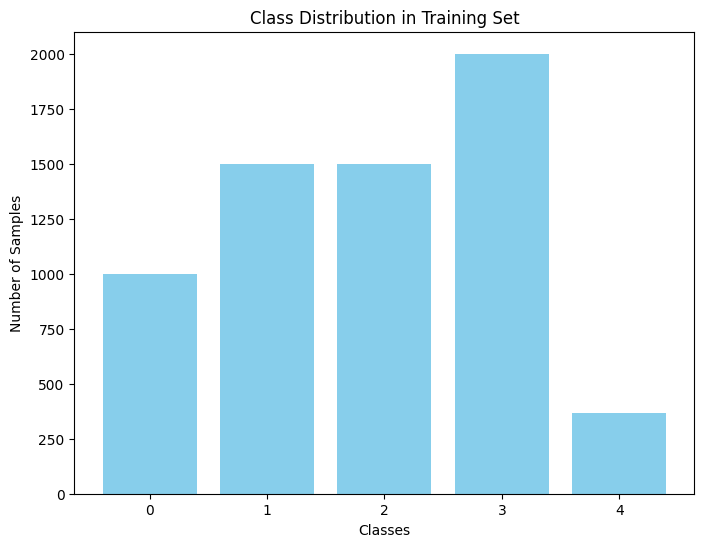

In [6]:
# Analyze Class Distribution
import matplotlib.pyplot as plt

# Count of samples per class
class_counts = train_generator.classes
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
plt.bar(class_names, [np.sum(class_counts == i) for i in range(len(class_names))], color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Set')
plt.show()

In [7]:
# Create Separate Generators for Minority Classes
import os

# Define the target size and batch size
target_size = (96, 96)
batch_size = 64

# Initialize data augmentation for minority classes
minority_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    shear_range=0.2,
    fill_mode='nearest'
)

# Paths to minority class directories
minority_classes = ['0', '4']
train_dir = 'train/'

augmented_generators = []

for cls in minority_classes:
    class_dir = os.path.join(train_dir, cls)
    if not os.path.isdir(class_dir):
        print(f"Directory for class {cls} not found. Skipping augmentation.")
        continue
    generator = minority_datagen.flow_from_directory(
        directory=train_dir,
        target_size=target_size,
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        classes=[cls],  # Only target the minority class
        shuffle=True
    )
    augmented_generators.append(generator)

print(f"Number of augmented generators: {len(augmented_generators)}")

Found 1000 images belonging to 1 classes.
Found 369 images belonging to 1 classes.
Number of augmented generators: 2


In [8]:
# Compute Class Weights
from sklearn.utils import class_weight
import numpy as np

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convert to a dictionary
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.2738, 1: 0.8492, 2: 0.8492, 3: 0.6369, 4: 3.4520325203252034}


In [9]:
# Combine Original and Augmented Generators
import itertools

# Create a combined generator
train_combined = itertools.chain(
    train_generator,
    *augmented_generators
)

# Define a generator that yields data from the combined generator
def combined_generator(combined):
    for data in combined:
        yield data

# Reset the iterator
train_combined = combined_generator(train_combined)

In [10]:
# Deeper CNN 
def DeepCNN(input_shape, num_classes):
    model = Sequential(name="DeepCNN")

    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with RMSprop optimizer
    optimizer = optimizers.RMSprop(learning_rate=0.001)

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model

# Instantiate and summarize the model
model_deep = DeepCNN(input_shape, num_classes)
model_deep.summary()

Model: "DeepCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 64)        36928     
                                                           

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.layers import LeakyReLU

def ImprovedDeepCNN(input_shape, num_classes):
    model = models.Sequential(name="ImprovedDeepCNN")
    
    # First Convolutional Block
    model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU())
    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    
    # Second Convolutional Block
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU())
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    
    # Third Convolutional Block
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU())
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))
    
    # Global Average Pooling and Dense Layers
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001)))
    model.add(LeakyReLU())
    model.add(layers.Dropout(0.5))
    
    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    # Compile the model with Adam optimizer
    optimizer = optimizers.Adam(learning_rate=0.0001)
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model

# Instantiate and summarize the improved model
model_improved = ImprovedDeepCNN(input_shape, num_classes)
model_improved.summary()

Model: "ImprovedDeepCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 96, 96, 32)    

In [12]:
# Cell 8: Define Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,  # Increased patience for potentially longer training
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,  # Increased patience
    verbose=1,
    min_lr=1e-6
)

# Optionally, add ModelCheckpoint to save the best model
checkpoint = callbacks.ModelCheckpoint(
    'models/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [ ]:
# Calculate steps per epoch and validation steps
steps_per_epoch = int(np.ceil(train_generator.n / batch_size))
val_steps = int(np.ceil(validation_generator.n / batch_size))

try:
    model_deep.fit(
        train_combined,
        epochs=100,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_generator,
        validation_steps=val_steps,
        callbacks=[early_stopping, reduce_lr, checkpoint],
        class_weight=class_weights_dict,
        verbose=1
    )
    
    model_improved.fit(
        train_combined,
        epochs=100,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_generator,
        validation_steps=val_steps,
        callbacks=[early_stopping, reduce_lr, checkpoint],
        class_weight=class_weights_dict,
        verbose=1
    )
except KeyboardInterrupt:
    print("Training interrupted.")

# Save the final models

model_deep.save('models/final_model_deep.keras')
model_improved.save('models/final_model_improved.keras')

Epoch 1/100
 63/200 [========>.....................] - ETA: 1:43 - loss: 2.0301 - accuracy: 0.1915

In [17]:
# Creating and evaluating the combined model

from tensorflow.keras.layers import Input, Average
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model

model_deep = load_model('models/final_model_deep.keras')
model_improved = load_model('models/final_model_improved.keras')

input_shape_deep = model_deep.input_shape[1:]  # Exclude batch size
input_shape_improved = model_improved.input_shape[1:]

assert input_shape_deep == input_shape_improved, "Input shapes of both models must be the same."

# Create an input layer that matches the input shape
input_layer = Input(shape=input_shape_deep)

# Get predictions from both models
preds_deep = model_deep(input_layer)
preds_improved = model_improved(input_layer)

# Average the outputs
averaged_preds = Average()([preds_deep, preds_improved])

# Create the combined model
combined_model = Model(inputs=input_layer, outputs=averaged_preds)

# Compile the combined model
combined_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Save the combined model
combined_model.save('models/combined_model.keras')

# Load the combined model
combined_model = load_model('models/combined_model.keras')

# Evaluate the model on the validation set
val_loss, val_acc = combined_model.evaluate(validation_generator, verbose=1)
print(f"Validation Accuracy: {val_acc:.4f}")

86/86 [==============================] - 13s 145ms/step - loss: 1.3630 - accuracy: 0.7043
Validation Accuracy: 0.7043


In [23]:
from tensorflow.keras.models import load_model

# Load the best saved model, either deep, improved, or combined
best_model = load_model('models/combined_model.keras')

# Evaluate on validation data
val_steps = int(np.ceil(validation_generator.n / batch_size))
loss, acc = best_model.evaluate(validation_generator, steps=val_steps, verbose=1)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')

86/86 [==============================] - 13s 144ms/step - loss: 1.3630 - accuracy: 0.7043
Loss: 1.3630
Accuracy: 0.7043


In [24]:
# Classification Report
preds = best_model.predict(validation_generator, steps=val_steps, verbose=0)
Ypred = np.argmax(preds, axis=1)
Ytest = validation_generator.classes  # Ensure shuffle=False in validation_generator

print(classification_report(Ytest, Ypred, target_names=classnames, digits=3))

              precision    recall  f1-score   support

           0      0.152     0.150     0.151       133
           1      0.638     0.135     0.222       275
           2      0.622     0.126     0.209       406
           3      0.738     0.964     0.836      1896
           4      0.000     0.000     0.000        39

    accuracy                          0.704      2749
   macro avg      0.430     0.275     0.284      2749
weighted avg      0.672     0.704     0.637      2749



c:\Users\andri\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andri\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\andri\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


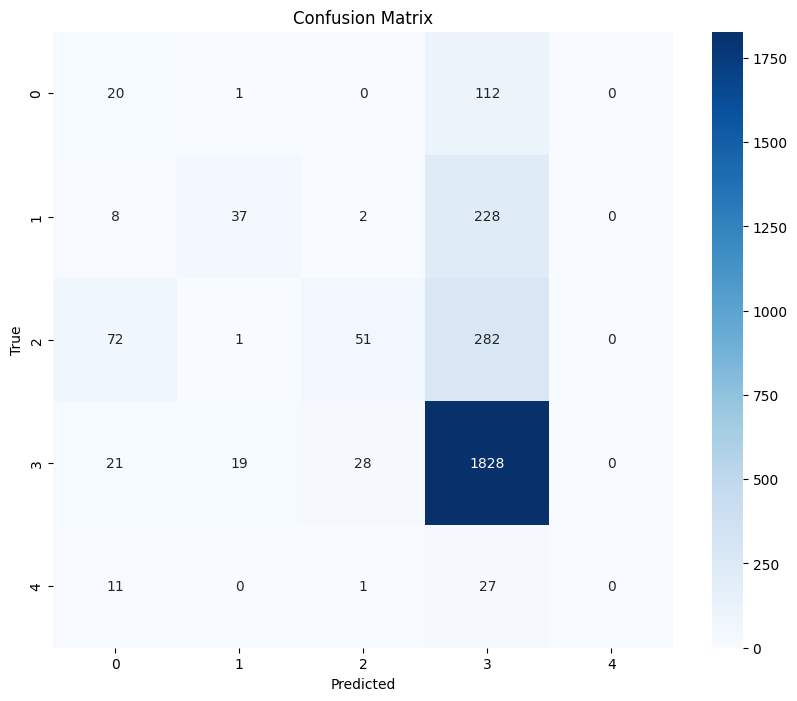

In [25]:
# Confusion Matrix
cm = confusion_matrix(Ytest, Ypred)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classnames, yticklabels=classnames, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Text-Based Confusion Matrix
conf = []
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i != j and cm[i][j] > 0:
            conf.append([i, j, cm[i][j]])

conf = np.array(conf)
conf = conf[np.argsort(-conf[:, 2])]  # Sort by descending error count

print(f'{"True":<16} {"Predicted":<16} {"Errors":<10} {"Error %":<10}')
print('-' * 60)
for k in conf:
    true_class = classnames[int(k[0])]
    pred_class = classnames[int(k[1])]
    errors = int(k[2])
    error_pct = (errors / validation_generator.n) * 100
    print(f'{true_class:<16} -> {pred_class:<16} {errors:<10} {error_pct:.2f}%')

In [ ]:
# Model Deployment with Gymnasium (Continuous Actions)
import numpy as np
from gymnasium.wrappers import RecordVideo

def play(env, model, predefined_actions):
    seed = 2000
    obs, _ = env.reset(seed=seed)

    # Drop initial frames with no action
    no_action = predefined_actions[0]  # [0.0, 0.0, 0.0]
    for _ in range(50):
        obs, _, _, _, _ = env.step(no_action)

    done = False
    while not done:
        # Preprocess the observation
        img = preprocess_observation(obs, target_size)
        p = model.predict(np.expand_dims(img, axis=0))  # Shape: (1, 5)
        predicted_class = np.argmax(p)  # Integer 0-4

        # Map the predicted class to a predefined action
        action = predefined_actions.get(predicted_class, predefined_actions[0])  # Array

        # Ensure the action is a float32 NumPy array
        action = np.array(action, dtype=np.float32)

        # Step the environment with the action
        obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    env.close()

def preprocess_observation(obs, target_size):
    from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

    # Convert observation to PIL Image
    img = array_to_img(obs)
    # Resize image
    img = img.resize(target_size)
    # Convert to array and normalize
    img = img_to_array(img) / 255.0
    return img

# Define predefined actions (Continuous)
predefined_actions = {
    0: np.array([0.0, 0.0, 0.0], dtype=np.float32),  # No Action
    1: np.array([-1.0, 0.0, 0.0], dtype=np.float32), # Steer Left
    2: np.array([1.0, 0.0, 0.0], dtype=np.float32),  # Steer Right
    3: np.array([0.0, 1.0, 0.0], dtype=np.float32),  # Accelerate (Gas)
    4: np.array([0.0, 0.0, 1.0], dtype=np.float32),  # Brake
}

# Initialize the environment without 'continuous' parameter
env_arguments = {
    'domain_randomize': False,
    'render_mode': 'rgb_array'
}

env_name = 'CarRacing-v3'
env = gym.make(env_name, **env_arguments)

# Wrap the environment to record videos
video_dir = 'video_recordings'
env = RecordVideo(env, video_dir)

print("Environment:", env_name)
print("Action space:", env.action_space)
print("Observation space:", env.observation_space)

# Play the game using the trained model
play(env, best_model, predefined_actions)

# (Optional Approach) Reinforcement Learning Model

In [1]:
import os
import json
import random
import cv2
import numpy as np
import gymnasium as gym
import datetime
import matplotlib.pyplot as plt
from collections import deque

import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses

# Set TensorFlow to use channels_first format
tf.keras.backend.set_image_data_format('channels_first')

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# UTIL FUNCTIONS
def write_json_to_file(data, file_path):
    with open(file_path, 'w') as json_file:
        json.dump(data, json_file, indent=4)


def make_all_paths(is_dynamic_root=True, dir_name="rl_class"):
    ROOT = "reinforcement_learning"
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") if is_dynamic_root else ""
    dir_name = f"{dir_name}_{timestamp}" if is_dynamic_root else dir_name
    path_root = os.path.join(ROOT, dir_name)
    for sub_dir in ["models", "plots", "videos"]:
        os.makedirs(os.path.join(path_root, sub_dir), exist_ok=True)
    return path_root + "/"


def preprocess_frame_car(frame):
    # Convert to grayscale, resize, and normalize
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = cv2.resize(frame, (96, 96)).astype(np.float32) / 255.0
    return frame


def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

print("Utility functions defined.")

Utility functions defined.


In [3]:
# CONFIG
class Config:
    SEED = random.randint(0, 1000)

    STARTING_EPISODE_TRAIN = 0
    ENDING_EPISODE_TRAIN = STARTING_EPISODE_TRAIN + 50

    STARTING_EPISODE_TEST = ENDING_EPISODE_TRAIN + 1
    ENDING_EPISODE_TEST = STARTING_EPISODE_TEST + 50

    SKIP_FRAMES = 2
    TRAINING_BATCH_SIZE = 32
    UPDATE_TARGET_MODEL_FREQUENCY = 5
    N_FRAMES = 3
    HIDDEN_DIMENSION_FC = 150

    GAS_WEIGHT = 1.3

    ACTION_SPACE = [
        (-1, 1, 0.2), (0, 1, 0.2), (1, 1, 0.2),
        (-1, 1, 0), (0, 1, 0), (1, 1, 0),
        (-1, 0, 0.2), (0, 0, 0.2), (1, 0, 0.2),
        (-1, 0, 0), (0, 0, 0), (1, 0, 0)
    ]

print("Configuration set.")

Configuration set.


In [4]:
# DQN MODEL
class DQN(tf.keras.Model):
    def __init__(self, n_frames, n_actions, h_dimension):
        super(DQN, self).__init__()
        self.conv1 = layers.Conv2D(
            6, kernel_size=(7, 7), strides=(3, 3), activation='relu', data_format='channels_first')
        self.pool1 = layers.MaxPooling2D(
            pool_size=(2, 2), data_format='channels_first')
        self.conv2 = layers.Conv2D(
            12, kernel_size=(4, 4), activation='relu', data_format='channels_first')
        self.pool2 = layers.MaxPooling2D(
            pool_size=(2, 2), data_format='channels_first')
        self.flatten = layers.Flatten()
        self.fc1 = layers.Dense(h_dimension, activation='relu')
        self.fc2 = layers.Dense(n_actions)

    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return self.fc2(x)
print("DQN model defined.")

DQN model defined.


In [5]:
# DQN AGENT
class DQNAgent:
    def __init__(self,
                 action_space,
                 epsilon=1.0,
                 gamma=0.95,
                 epsilon_min=0.1,
                 epsilon_decay=0.9999,
                 lr=1e-3,
                 memory_len=5000,
                 frames=3,
                 hidden_dimension=150):
        self.epsilon = epsilon
        self.gamma = gamma
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.memory = deque(maxlen=memory_len)
        self.action_space = action_space
        self.n_actions = len(action_space)

        self.model = DQN(frames, self.n_actions, hidden_dimension)
        self.target_model = DQN(frames, self.n_actions, hidden_dimension)
        self.model.build((None, frames, 96, 96))
        self.target_model.build((None, frames, 96, 96))
        self.target_model.set_weights(self.model.get_weights())

        self.optimizer = optimizers.Adam(learning_rate=lr)
        self.loss_fn = losses.MeanSquaredError()

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def is_explore(self):
        return random.random() < self.epsilon

    def act(self, state, is_only_random=False, is_only_exploit=False):
        if (not is_only_exploit and self.is_explore()) or is_only_random:
            action_index = np.random.randint(self.n_actions)
            print(f"Exploring: Taking random action index {action_index}")
        else:
            q_values_dict = self.target_model(state, training=False)
            # Extract the tensor from the dict; assuming the key is 'output_1'
            q_values = q_values_dict['output_1']
            q_values = tf.squeeze(q_values)  # Shape: (n_actions,)
            action_index = tf.argmax(q_values).numpy()
            print(f"Exploiting: Q-values {q_values.numpy()}, taking action index {action_index}")
        return self.action_space[action_index]


    def memorize(self, state, action, reward, next_state, done):
        action_index = self.action_space.index(action)
        self.memory.append((state, action_index, reward, next_state, done))

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = tf.convert_to_tensor(states, dtype=tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.int32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        dones = tf.convert_to_tensor(dones, dtype=tf.float32)

        with tf.GradientTape() as tape:
            q_values = self.model(states, training=True)
            q_selected = tf.reduce_sum(
                q_values * tf.one_hot(actions, self.n_actions), axis=1)

            q_next = self.target_model(next_states, training=False)
            max_q_next = tf.reduce_max(q_next, axis=1)
            target = rewards + (1 - dones) * self.gamma * max_q_next

            loss = self.loss_fn(target, q_selected)

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def save_model(self, path):
        self.model.save(path, save_format="tf")

    def load_model(self, path):
        self.model = tf.keras.layers.TFSMLayer(path, call_endpoint='serving_default')
        self.target_model = tf.keras.layers.TFSMLayer(path, call_endpoint='serving_default')
        #self.model = tf.keras.models.load_model(path)
        #self.target_model = tf.keras.models.load_model(path)

print("DQN agent defined.")

DQN agent defined.


In [6]:
# MAIN TRAINING LOOP
def train_car_racing():
    seed_everything(Config.SEED)
    path_root = make_all_paths(is_dynamic_root=True)
    write_json_to_file(Config.__dict__, os.path.join(path_root, "config.json"))

    agent = DQNAgent(
        action_space=Config.ACTION_SPACE,
        frames=Config.N_FRAMES,
        hidden_dimension=Config.HIDDEN_DIMENSION_FC
    )

    env = gym.make('CarRacing-v3', render_mode="rgb_array")
    env = gym.wrappers.RecordVideo(
        env, os.path.join(path_root, 'videos'),
        episode_trigger=lambda x: x % Config.UPDATE_TARGET_MODEL_FREQUENCY == 0
    )

    epi_total_rewards = []
    for episode in range(Config.STARTING_EPISODE_TRAIN, Config.ENDING_EPISODE_TRAIN + 1):
        state, _ = env.reset(seed=episode)
        state = preprocess_frame_car(state)
        state_queue = deque([state] * Config.N_FRAMES, maxlen=Config.N_FRAMES)
        epi_total_reward = 0
        epi_negative_reward_counter = 0

        while True:
            state_array = np.array(state_queue)
            state_tensor = tf.convert_to_tensor(state_array, dtype=tf.float32)[None, ...]

            action = agent.act(state_tensor)
            reward = 0
            done = False

            for _ in range(Config.SKIP_FRAMES):
                next_state, r, done, truncated, _ = env.step(action)
                reward += r
                if done or truncated:
                    break

            if epi_total_reward > 100 and reward < 0:
                epi_negative_reward_counter += 1
            else:
                epi_negative_reward_counter = 0

            if action[1] == 1 and action[2] == 0:
                reward *= Config.GAS_WEIGHT

            epi_total_reward += reward

            next_state = preprocess_frame_car(next_state)
            state_queue.append(next_state)

            next_state_array = np.array(state_queue)
            next_state_tensor = tf.convert_to_tensor(next_state_array, dtype=tf.float32)[None, ...]

            agent.memorize(state_tensor, action, reward, next_state_tensor, done)

            if epi_negative_reward_counter >= 25 or epi_total_reward < 0 or done:
                break

            if len(agent.memory) > Config.TRAINING_BATCH_SIZE:
                agent.replay(Config.TRAINING_BATCH_SIZE)

        epi_total_rewards.append(epi_total_reward)
        print(f"Episode: {episode}/{Config.ENDING_EPISODE_TRAIN}, "
              f"Total Reward: {epi_total_reward:.2f}, Epsilon: {agent.epsilon:.4f}")

        if episode % Config.UPDATE_TARGET_MODEL_FREQUENCY == 0:
            plt.plot(epi_total_rewards, label="Cumulative Reward")
            plt.title("Training Progress")
            plt.savefig(os.path.join(path_root, 'plots', f'reward_{episode}.pdf'))
            plt.clf()

            agent.save_model(os.path.join(path_root, "models", f"model_{episode}"))
            agent.update_target_model()
            write_json_to_file({"CUM_REW": epi_total_rewards}, os.path.join(path_root, "stats.json"))

    env.close()
    
print("Training loop defined.")

Training loop defined.


In [7]:
# TEST FUNCTION
def test_car_racing(model_to_load):
    seed_everything(Config.SEED)
    agent = DQNAgent(
        action_space=Config.ACTION_SPACE,
        frames=Config.N_FRAMES,
        hidden_dimension=Config.HIDDEN_DIMENSION_FC
    )
    agent.load_model(model_to_load)

    env = gym.make('CarRacing-v3', render_mode="human")
    PICKED_EPISODES = [1]

    for episode in PICKED_EPISODES:
        state, _ = env.reset(seed=episode)
        state = preprocess_frame_car(state)
        state_queue = deque([state] * Config.N_FRAMES, maxlen=Config.N_FRAMES)
        epi_negative_reward_counter = 0

        while True:
            state_array = np.array(state_queue)
            state_tensor = tf.convert_to_tensor(state_array, dtype=tf.float32)[None, ...]

            action = agent.act(state_tensor, is_only_exploit=True)
            reward = 0
            done = False

            for _ in range(Config.SKIP_FRAMES):
                next_state, r, done, truncated, _ = env.step(action)
                reward += r
                if done or truncated:
                    break

            if reward <= 0:
                epi_negative_reward_counter += 1
            else:
                epi_negative_reward_counter = 0

            if epi_negative_reward_counter >= 100:
                break

            next_state = preprocess_frame_car(next_state)
            state_queue.append(next_state)

    env.close()

print("Test function defined.")

Test function defined.


In [8]:
# To train:
train_car_racing()

In [ ]:
# To test:
path = "reinforcement_learning/rl_class_20241210_132210/models/model_50"
test_car_racing(model_to_load=path)

c:\Users\andri\miniconda3\envs\cv\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'dqn_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
c:\Users\andri\miniconda3\envs\cv\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'dqn_7', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Exploiting: Q-values [0.7148117  0.55270165 0.6458195  0.4441452  0.7048035  0.5863819
 0.47603256 0.43599784 0.88186985 0.88889724 0.398117   0.88782   ], taking action index 9
Exploiting: Q-values [0.80034333 0.69461995 0.8322952  0.80973226 0.790777   0.62624335
 0.8062163  0.56987786 0.775394   0.841416   0.7877411  0.8183331 ], taking action index 9
Exploiting: Q-values [0.6654079  0.5894695  0.6553817  0.6844714  0.6606878  0.608169
 0.65457064 0.5941453  0.69504654 0.6882259  0.661561   0.7143706 ], taking action index 11
Exploiting: Q-values [0.6606034  0.6224391  0.70355844 0.72250426 0.65515304 0.62275916
 0.6593912  0.63895357 0.6661563  0.641134   0.6960231  0.70138687], taking action index 3
Exploiting: Q-values [0.6391903  0.6475189  0.73205924 0.7304424  0.64235383 0.6566068
 0.6317541  0.6564933  0.6615238  0.6615246  0.6712896  0.688876  ], taking action index 2
Exploiting: Q-values [0.6119086  0.61285675 0.6891151  0.6764548  0.6247977  0.612184
 0.628247   0.60776126